In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu May 11 15:28:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
!nvidia-smi

Thu May 11 15:28:32 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!lscpu |grep 'Model name'

Model name:                      Intel(R) Xeon(R) CPU @ 2.00GHz


In [ ]:
!lscpu | grep "Clock frequency in MHz:"

In [ ]:
#!pip install tensorflow==2.8.0
#!pip install tensorflow_gpu==2.8.0
#!pip install tensorflow==2.12.0
#!pip install tensorflow_gpu==2.12.0
!pip install Pillow==8.3.0
!pip install keras-unet-collection
!pip install focal-loss

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 MB 17.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
#!pip install matplotlib==3.6

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
%matplotlib inline

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
print('TensorFlow {}; Keras {}'.format(tf.__version__, keras.__version__))

In [ ]:
from tensorflow.keras.metrics import MeanIoU

In [ ]:
from keras_unet_collection import models, utils,losses

In [ ]:
import os
import numpy as np
from tensorflow.keras.optimizers import Adam
from datetime import datetime
import cv2
from PIL import Image

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
from keras.models import load_model

In [ ]:
seed=54
batch_size= 4
n_classes=3
img_dim = 400

In [ ]:
def trainGenerator(train_img_path, train_mask_path):

    # img_data_gen_args = dict(horizontal_flip=True,
    #                   vertical_flip=True,
    #                   fill_mode='reflect')

    # image_datagen = ImageDataGenerator(**img_data_gen_args)
    # mask_datagen = ImageDataGenerator(**img_data_gen_args)
    image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator()

    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        target_size = (img_dim,img_dim),
        class_mode = None,
        batch_size = batch_size,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        target_size = (img_dim,img_dim),
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)

    train_generator = zip(image_generator, mask_generator)

    for (img, mask) in train_generator:
        #img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [ ]:
def evaluateGenerator(train_img_path, train_mask_path):

    # img_data_gen_args = dict(horizontal_flip=True,
    #                   vertical_flip=True,
    #                   fill_mode='reflect')

    # image_datagen = ImageDataGenerator(**img_data_gen_args)
    # mask_datagen = ImageDataGenerator(**img_data_gen_args)
    image_datagen = ImageDataGenerator()
    mask_datagen = ImageDataGenerator()

    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        target_size = (img_dim,img_dim),
        class_mode = None,
        batch_size = 1,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        target_size = (img_dim,img_dim),
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = 1,
        seed = seed)

    train_generator = zip(image_generator, mask_generator)

    for (img, mask) in train_generator:
        #img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [ ]:
len(os.listdir('/content/gdrive/MyDrive/cracks-and-potholes-in-road-test/All images/img'))

504

In [ ]:
len(os.listdir('/content/gdrive/MyDrive/cracks-and-potholes-in-road-test/All preprocessed masks/img'))

504

In [ ]:
train_img_path = '/content/gdrive/MyDrive/Limited_Dataset_Train/images/'
train_mask_path = '/content/gdrive/MyDrive/Limited_Dataset_Train/masks/'

train_img_gen = trainGenerator(train_img_path, train_mask_path)

In [ ]:
val_img_path = '/content/gdrive/MyDrive/Limited_Dataset_Val/images/'
val_mask_path = '/content/gdrive/MyDrive/Limited_Dataset_Val/masks/'

val_img_gen = trainGenerator(val_img_path, val_mask_path)

In [ ]:
test_img_path = '/content/gdrive/MyDrive/cracks-and-potholes-in-road-test/All images'
test_mask_path = '/content/gdrive/MyDrive/cracks-and-potholes-in-road-test/All preprocessed masks'

test_img_gen = evaluateGenerator(test_img_path, test_mask_path)

In [ ]:
actual_val_img_path = '/content/gdrive/MyDrive/cracks-and-potholes-in-road-val/images'
actual_val_mask_path = '/content/gdrive/MyDrive/cracks-and-potholes-in-road-val/masks'
actual_val_img_gen = evaluateGenerator(actual_val_img_path, actual_val_mask_path)

In [ ]:
x, y = train_img_gen.__next__()

Found 3991 images belonging to 1 classes.
Found 3991 images belonging to 1 classes.


In [ ]:
x_val, y_val = val_img_gen.__next__()

Found 192 images belonging to 1 classes.
Found 192 images belonging to 1 classes.


In [ ]:
x_test,y_test = test_img_gen.__next__()

Found 504 images belonging to 1 classes.
Found 504 images belonging to 1 classes.


In [ ]:
x_actual_val,y_actual_val = actual_val_img_gen.__next__()

Found 496 images belonging to 1 classes.
Found 496 images belonging to 1 classes.


/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


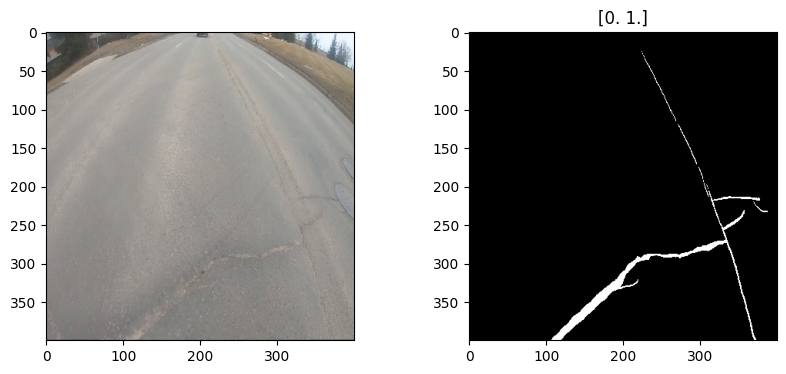

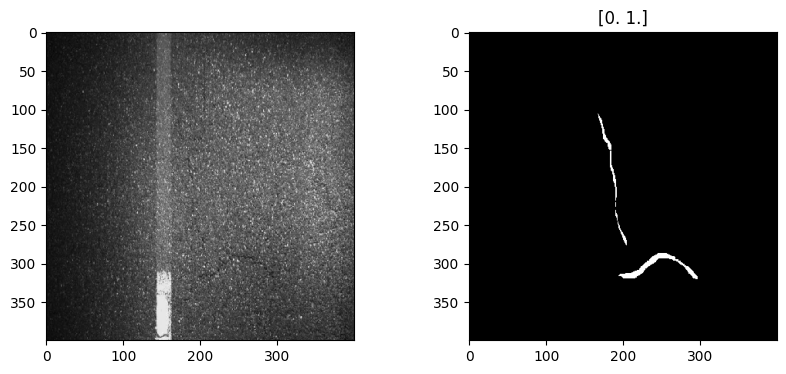

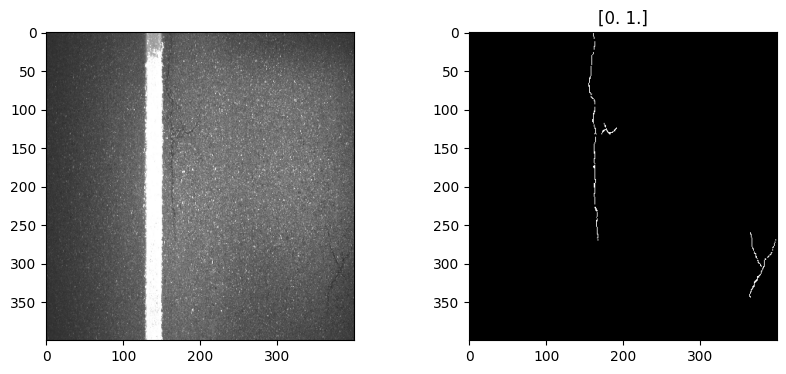

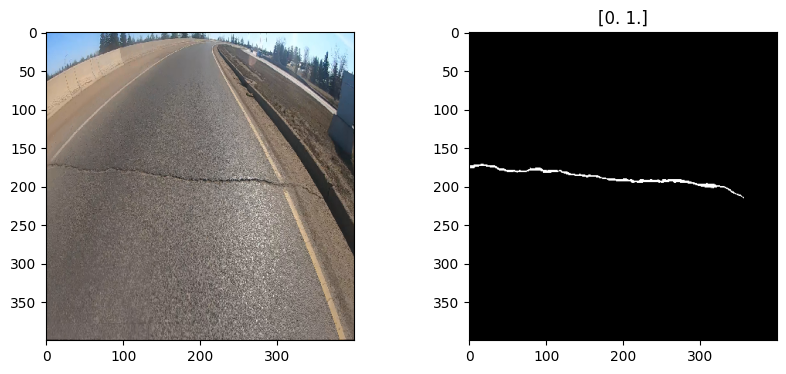

In [ ]:
for i in range(0,4):
  fig, axs = plt.subplots(1 , 2, figsize=(10,4))
  image = x[i]
  mask = y[i]
  axs[0].imshow(image.astype('uint8'))
  axs[1].imshow(mask,cmap='gray')
  axs[1].set_title(np.unique(mask))
  plt.show()

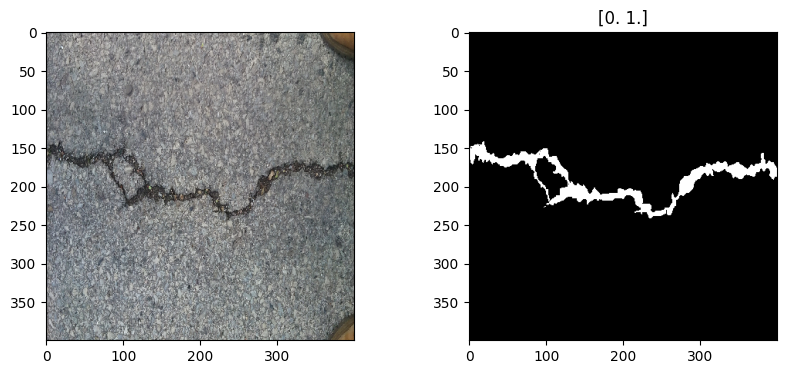

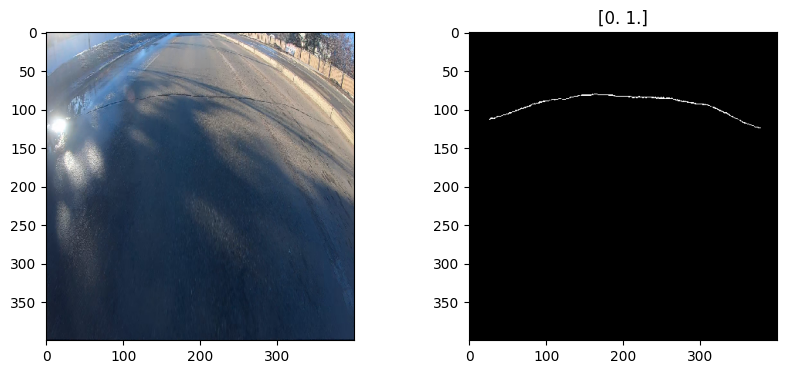

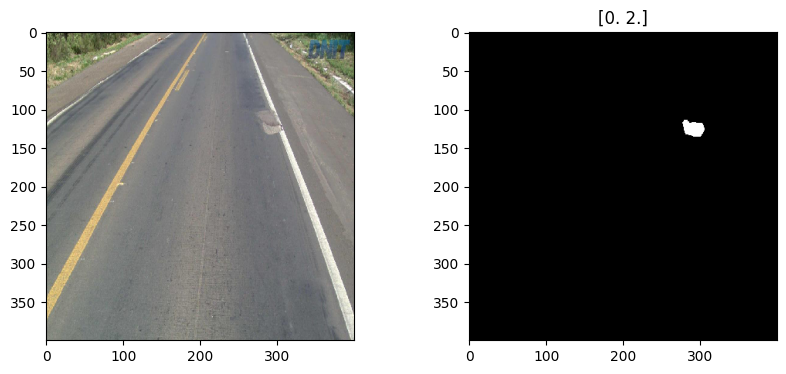

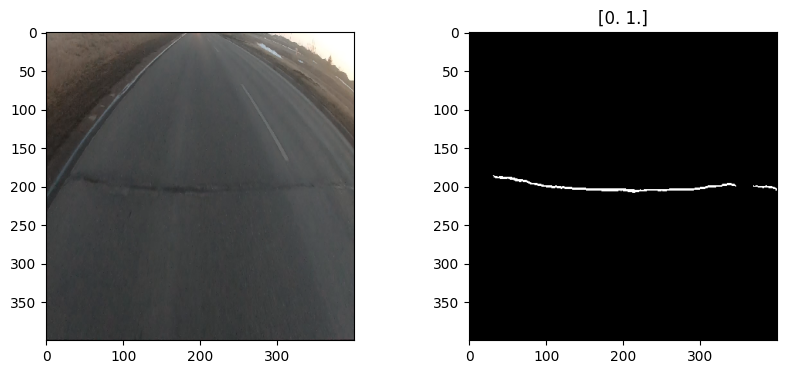

In [ ]:
for i in range(0,4):
  fig, axs = plt.subplots(1 , 2, figsize=(10,4))
  image = x_val[i]
  mask = y_val[i]
  axs[0].imshow(image.astype('uint8'))
  axs[1].imshow(mask,cmap='gray')
  axs[1].set_title(np.unique(mask))
  plt.show()

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


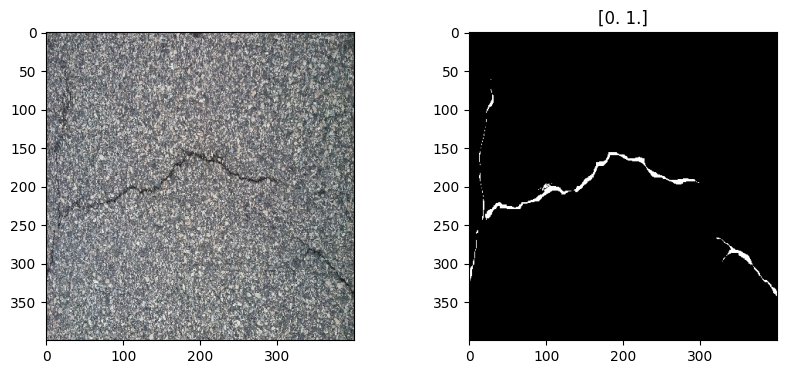

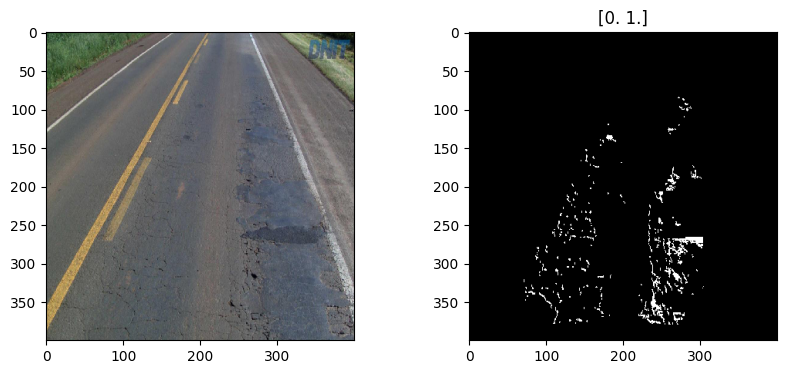

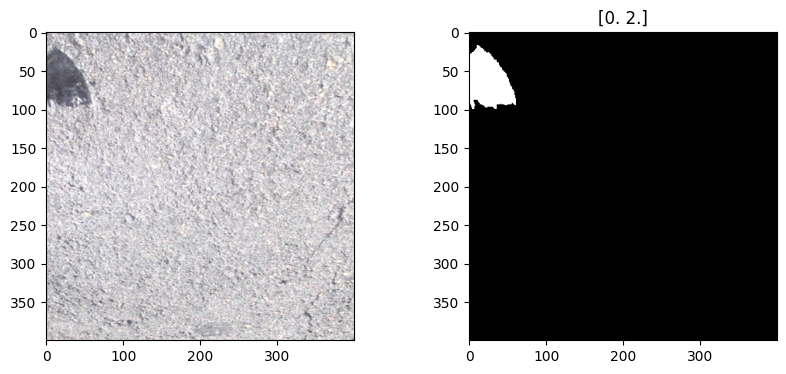

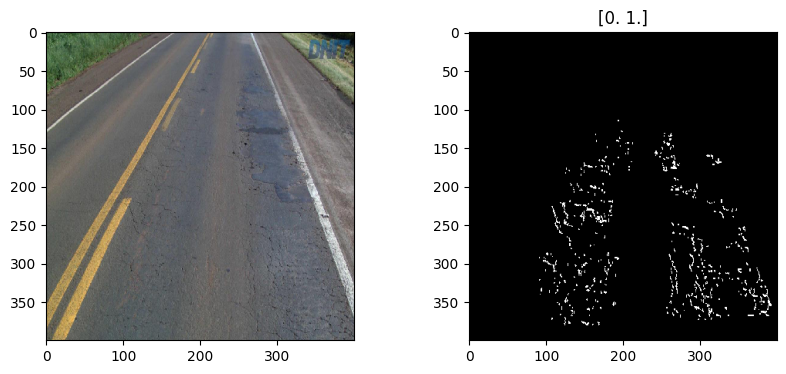

In [ ]:
for i in range(0,4):
  fig, axs = plt.subplots(1 , 2, figsize=(10,4))
  image = x_test[i]
  mask = y_test[i]
  axs[0].imshow(image.astype('uint8'))
  axs[1].imshow(mask,cmap='gray')
  axs[1].set_title(np.unique(mask))
  plt.show()

In [ ]:
# 0-> Background, 1-> Crack, 2-> Pothole
# For reference: 992866_RS_386_386RS191729_01095

In [ ]:
x.shape

(16, 400, 400, 3)

In [ ]:
y.shape

(16, 400, 400, 1)

In [ ]:
x_val.shape

(4, 400, 400, 3)

In [ ]:
y_val.shape

(4, 400, 400, 1)

In [ ]:
# MODEL Training

In [ ]:
help(models.unet_3plus_2d)

Help on function unet_3plus_2d in module keras_unet_collection._model_unet_3plus_2d:

unet_3plus_2d(input_size, n_labels, filter_num_down, filter_num_skip='auto', filter_num_aggregate='auto', stack_num_down=2, stack_num_up=1, activation='ReLU', output_activation='Sigmoid', batch_norm=False, pool=True, unpool=True, deep_supervision=False, backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet3plus')
    UNET 3+ with an optional ImageNet-trained backbone.
    
    unet_3plus_2d(input_size, n_labels, filter_num_down, filter_num_skip='auto', filter_num_aggregate='auto', 
                  stack_num_down=2, stack_num_up=1, activation='ReLU', output_activation='Sigmoid',
                  batch_norm=False, pool=True, unpool=True, deep_supervision=False, 
                  backbone=None, weights='imagenet', freeze_backbone=True, freeze_batch_norm=True, name='unet3plus')
                  
    ----------
    Huang, H., Lin, L., Tong, R., Hu, H., Zhang, Q., 

In [ ]:
IMG_HEIGHT = img_dim
IMG_WIDTH  = img_dim
IMG_CHANNELS = 3
num_labels = 3  #Cracks, pothole, background
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

In [ ]:
num_train_imgs = len(os.listdir(train_img_path+'img'))
num_val_imgs = len(os.listdir(val_img_path+'img'))


In [ ]:
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_imgs//batch_size

In [ ]:
steps_per_epoch

997

In [ ]:
unet3plus = models.unet_3plus_2d(input_shape, n_labels=num_labels,
                             filter_num_down=[64, 128, 256,512],
                             filter_num_skip='auto', filter_num_aggregate='auto',
                             stack_num_down=2, stack_num_up=1, activation='ReLU',
                             output_activation='Softmax', batch_norm=True,
                             pool='max', unpool=False, deep_supervision=True,
                             backbone='EfficientNetB3',weights='imagenet',
                             freeze_backbone=True,freeze_batch_norm=True,
                             name='unet3plus')

Automated hyper-parameter determination is applied with the following details:
----------
	Number of convolution filters after each full-scale skip connection: filter_num_skip = [64, 64, 64]
	Number of channels of full-scale aggregated feature maps: filter_num_aggregate = 256
----------
deep_supervision = True
names of output tensors are listed as follows ("sup0" is the shallowest supervision layer;
"final" is the final output layer):

	unet3plus_output_sup0_activation
	unet3plus_output_sup1_activation
	unet3plus_output_sup2_activation
	unet3plus_output_final_activation


In [ ]:
# unet3plus.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                   optimizer=keras.optimizers.Adam(learning_rate=1e-4),
#                   metrics=[tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.MeanIoU(num_classes=3)])
unet3plus.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
print(unet3plus.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 400, 400, 3  0           []                               
                                )]                                                                
                                                                                                  
 EfficientNetB3_backbone (Funct  [(None, 200, 200, 1  184645     ['input_3[0][0]']                
 ional)                         44),                                                              
                                 (None, 100, 100, 1                                               
                                92),                                                              
                                 (None, 50, 50, 288                                         

In [ ]:
model_path = '/content/gdrive/MyDrive/unet models/limited_dataset_training_unet3plus.hdf5'
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)

In [ ]:
history = unet3plus.fit(train_img_gen,
                        validation_data=val_img_gen,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=val_steps_per_epoch,
                   verbose=1,
                   batch_size = batch_size,
                   epochs=1,
                   callbacks=[earlystop,checkpoint]
                   )




701/701 [==============================] - ETA: 0s - loss: 1.9458 - unet3plus_output_sup0_activation_loss: 0.1531 - unet3plus_output_sup1_activation_loss: 0.7439 - unet3plus_output_sup2_activation_loss: 0.9729 - unet3plus_output_final_activation_loss: 0.0760 - unet3plus_output_sup0_activation_sparse_categorical_accuracy: 0.9598 - unet3plus_output_sup1_activation_sparse_categorical_accuracy: 0.8846 - unet3plus_output_sup2_activation_sparse_categorical_accuracy: 0.9612 - unet3plus_output_final_activation_sparse_categorical_accuracy: 0.9810Found 192 images belonging to 1 classes.
Found 192 images belonging to 1 classes.

Epoch 00001: val_loss improved from inf to 1.60198, saving model to /content/gdrive/MyDrive/unet models/limited_dataset_training_unet3plus.hdf5
701/701 [==============================] - 2947s 4s/step - loss: 1.9458 - unet3plus_output_sup0_activation_loss: 0.1531 - unet3plus_output_sup1_activation_loss: 0.7439 - unet3plus_output_sup2_activation_loss: 0.9729 - unet3plus_ou

In [ ]:
model_one_epoch = load_model('/content/gdrive/MyDrive/unet models/limited_dataset_training_unet3plus.hdf5')

In [ ]:
# model_one_epoch.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
#                   optimizer=keras.optimizers.Adam(learning_rate=1e-4),
#                   metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [ ]:
# Continuing training
history = model_one_epoch.fit(train_img_gen,
                        validation_data=val_img_gen,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=val_steps_per_epoch,
                   verbose=1,
                   batch_size = batch_size,
                   epochs=4,
                   initial_epoch=1,
                   callbacks=[earlystop,checkpoint]
                   )




Epoch 2/4
701/701 [==============================] - ETA: 0s - loss: 1.4384 - unet3plus_output_sup0_activation_loss: 0.0594 - unet3plus_output_sup1_activation_loss: 0.4765 - unet3plus_output_sup2_activation_loss: 0.8519 - unet3plus_output_final_activation_loss: 0.0507 - unet3plus_output_sup0_activation_sparse_categorical_accuracy: 0.9844 - unet3plus_output_sup1_activation_sparse_categorical_accuracy: 0.9849 - unet3plus_output_sup2_activation_sparse_categorical_accuracy: 0.9848 - unet3plus_output_final_activation_sparse_categorical_accuracy: 0.9853
Epoch 00002: val_loss improved from inf to 1.43985, saving model to /content/gdrive/MyDrive/unet models/limited_dataset_training_unet3plus.hdf5
701/701 [==============================] - 872s 1s/step - loss: 1.4384 - unet3plus_output_sup0_activation_loss: 0.0594 - unet3plus_output_sup1_activation_loss: 0.4765 - unet3plus_output_sup2_activation_loss: 0.8519 - unet3plus_output_final_activation_loss: 0.0507 - unet3plus_output_sup0_activation_spa

In [ ]:
model_four_epoch = load_model('/content/gdrive/MyDrive/unet models/limited_dataset_training_unet3plus.hdf5')

In [ ]:
# Continuing training
history = model_one_epoch.fit(train_img_gen,
                        validation_data=val_img_gen,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=val_steps_per_epoch,
                   verbose=1,
                   batch_size = batch_size,
                   epochs=50,
                   initial_epoch=4,
                   callbacks=[earlystop,checkpoint]
                   )




Epoch 5/50
701/701 [==============================] - ETA: 0s - loss: 1.1121 - unet3plus_output_sup0_activation_loss: 0.0407 - unet3plus_output_sup1_activation_loss: 0.3746 - unet3plus_output_sup2_activation_loss: 0.6580 - unet3plus_output_final_activation_loss: 0.0388 - unet3plus_output_sup0_activation_sparse_categorical_accuracy: 0.9875 - unet3plus_output_sup1_activation_sparse_categorical_accuracy: 0.9851 - unet3plus_output_sup2_activation_sparse_categorical_accuracy: 0.9846 - unet3plus_output_final_activation_sparse_categorical_accuracy: 0.9874
Epoch 00005: val_loss improved from inf to 1.12561, saving model to /content/gdrive/MyDrive/unet models/limited_dataset_training_unet3plus.hdf5
701/701 [==============================] - 857s 1s/step - loss: 1.1121 - unet3plus_output_sup0_activation_loss: 0.0407 - unet3plus_output_sup1_activation_loss: 0.3746 - unet3plus_output_sup2_activation_loss: 0.6580 - unet3plus_output_final_activation_loss: 0.0388 - unet3plus_output_sup0_activation_sp

UnknownError: ignored

In [ ]:
model_thirtythree_epoch = load_model('/content/gdrive/MyDrive/unet models/limited_dataset_training_unet3plus.hdf5')

In [ ]:
model_thirtythree_epoch.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=keras.optimizers.Adam(learning_rate=1e-4),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.MeanIoU(num_classes=3,sparse_y_pred=False)])

In [ ]:
# Continuing training
history = model_thirtythree_epoch.fit(train_img_gen,
                        validation_data=val_img_gen,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=val_steps_per_epoch,
                   verbose=1,
                   batch_size = batch_size,
                   epochs=50,
                   initial_epoch=33,
                   callbacks=[earlystop,checkpoint]
                   )




Epoch 34/50
701/701 [==============================] - ETA: 0s - loss: 0.1820 - unet3plus_output_sup0_activation_loss: 0.0164 - unet3plus_output_sup1_activation_loss: 0.0578 - unet3plus_output_sup2_activation_loss: 0.0922 - unet3plus_output_final_activation_loss: 0.0155 - unet3plus_output_sup0_activation_sparse_categorical_accuracy: 0.9941 - unet3plus_output_sup0_activation_mean_io_u_1: 0.7748 - unet3plus_output_sup1_activation_sparse_categorical_accuracy: 0.9887 - unet3plus_output_sup1_activation_mean_io_u_1: 0.5382 - unet3plus_output_sup2_activation_sparse_categorical_accuracy: 0.9849 - unet3plus_output_sup2_activation_mean_io_u_1: 0.3441 - unet3plus_output_final_activation_sparse_categorical_accuracy: 0.9944 - unet3plus_output_final_activation_mean_io_u_1: 0.7836
Epoch 00034: val_loss improved from inf to 0.38081, saving model to /content/gdrive/MyDrive/unet models/limited_dataset_training_unet3plus.hdf5
701/701 [==============================] - 3488s 5s/step - loss: 0.1820 - unet3

In [ ]:
# Testing model

In [ ]:
model_complete_scce = load_model('/content/gdrive/MyDrive/unet models/limited_dataset_training_unet3plus.hdf5')

In [ ]:
model_complete_scce.compile(metrics=[tf.keras.metrics.SparseCategoricalAccuracy(),
                                     tf.keras.metrics.MeanIoU(num_classes=3,sparse_y_pred=False),
                                     tf.keras.metrics.IoU(num_classes=3,sparse_y_pred=False,target_class_ids=[1],name='crack_iou'),
                                     tf.keras.metrics.IoU(num_classes=3,sparse_y_pred=False,target_class_ids=[2],name='pothole_iou')
                                     ])

In [ ]:
#num_test_imgs = len(os.listdir(test_img_path+'/img'))
test_steps_per_epoch = len(os.listdir(test_img_path+'/img'))


In [ ]:
model_complete_scce.metrics_names

['loss',
 'unet3plus_output_sup0_activation_sparse_categorical_accuracy',
 'unet3plus_output_sup0_activation_mean_io_u_1',
 'unet3plus_output_sup0_activation_crack_iou',
 'unet3plus_output_sup0_activation_pothole_iou',
 'unet3plus_output_sup1_activation_sparse_categorical_accuracy',
 'unet3plus_output_sup1_activation_mean_io_u_1',
 'unet3plus_output_sup1_activation_crack_iou',
 'unet3plus_output_sup1_activation_pothole_iou',
 'unet3plus_output_sup2_activation_sparse_categorical_accuracy',
 'unet3plus_output_sup2_activation_mean_io_u_1',
 'unet3plus_output_sup2_activation_crack_iou',
 'unet3plus_output_sup2_activation_pothole_iou',
 'unet3plus_output_final_activation_sparse_categorical_accuracy',
 'unet3plus_output_final_activation_mean_io_u_1',
 'unet3plus_output_final_activation_crack_iou',
 'unet3plus_output_final_activation_pothole_iou']

In [ ]:
model_complete_scce.evaluate(test_img_gen,steps=test_steps_per_epoch)

504/504 [==============================] - 80s 159ms/step - loss: 0.0000e+00 - unet3plus_output_sup0_activation_sparse_categorical_accuracy: 0.9263 - unet3plus_output_sup0_activation_mean_io_u_1: 0.5054 - unet3plus_output_sup0_activation_crack_iou: 0.4068 - unet3plus_output_sup0_activation_pothole_iou: 0.1843 - unet3plus_output_sup1_activation_sparse_categorical_accuracy: 0.9380 - unet3plus_output_sup1_activation_mean_io_u_1: 0.4225 - unet3plus_output_sup1_activation_crack_iou: 0.2070 - unet3plus_output_sup1_activation_pothole_iou: 0.1231 - unet3plus_output_sup2_activation_sparse_categorical_accuracy: 0.9539 - unet3plus_output_sup2_activation_mean_io_u_1: 0.3370 - unet3plus_output_sup2_activation_crack_iou: 0.0390 - unet3plus_output_sup2_activation_pothole_iou: 0.0181 - unet3plus_output_final_activation_sparse_categorical_accuracy: 0.9302 - unet3plus_output_final_activation_mean_io_u_1: 0.5094 - unet3plus_output_final_activation_crack_iou: 0.4107 - unet3plus_output_final_activation_pot

[0.0,
 0.9263402819633484,
 0.5053625702857971,
 0.4067979156970978,
 0.1843063086271286,
 0.9379569292068481,
 0.4225218594074249,
 0.2069997638463974,
 0.12310314923524857,
 0.9539066553115845,
 0.3370016813278198,
 0.03903740644454956,
 0.018091334030032158,
 0.9302490949630737,
 0.5093620419502258,
 0.410652220249176,
 0.1884402185678482]

In [ ]:
# Accuracy on selected validation dataset
val_steps_per_epoch =len(os.listdir(val_img_path+'/img'))

In [ ]:
model_complete_scce.evaluate(val_img_gen,steps=val_steps_per_epoch)

192/192 [==============================] - 28s 147ms/step - loss: 0.0000e+00 - unet3plus_output_sup0_activation_sparse_categorical_accuracy: 0.9838 - unet3plus_output_sup0_activation_mean_io_u_1: 0.6239 - unet3plus_output_sup0_activation_crack_iou: 0.4942 - unet3plus_output_sup0_activation_pothole_iou: 0.3937 - unet3plus_output_sup1_activation_sparse_categorical_accuracy: 0.9807 - unet3plus_output_sup1_activation_mean_io_u_1: 0.4841 - unet3plus_output_sup1_activation_crack_iou: 0.2571 - unet3plus_output_sup1_activation_pothole_iou: 0.2145 - unet3plus_output_sup2_activation_sparse_categorical_accuracy: 0.9785 - unet3plus_output_sup2_activation_mean_io_u_1: 0.3442 - unet3plus_output_sup2_activation_crack_iou: 0.0468 - unet3plus_output_sup2_activation_pothole_iou: 0.0072 - unet3plus_output_final_activation_sparse_categorical_accuracy: 0.9845 - unet3plus_output_final_activation_mean_io_u_1: 0.6299 - unet3plus_output_final_activation_crack_iou: 0.4991 - unet3plus_output_final_activation_pot

[0.0,
 0.9838329553604126,
 0.6238927245140076,
 0.4941938817501068,
 0.39372339844703674,
 0.9806946516036987,
 0.4840591847896576,
 0.2570575475692749,
 0.2144523561000824,
 0.9785463809967041,
 0.3441692590713501,
 0.0467594638466835,
 0.007200841326266527,
 0.9845311045646667,
 0.6299067735671997,
 0.4990934133529663,
 0.4061664044857025]

In [ ]:
# Accuracy on actual validation dataset
num_steps = 496

In [ ]:
model_complete_scce.evaluate(actual_val_img_gen,steps=num_steps)

496/496 [==============================] - 691s 1s/step - loss: 0.0000e+00 - unet3plus_output_sup0_activation_sparse_categorical_accuracy: 0.9672 - unet3plus_output_sup0_activation_mean_io_u_1: 0.4917 - unet3plus_output_sup0_activation_crack_iou: 0.3015 - unet3plus_output_sup0_activation_pothole_iou: 0.2061 - unet3plus_output_sup1_activation_sparse_categorical_accuracy: 0.9718 - unet3plus_output_sup1_activation_mean_io_u_1: 0.4181 - unet3plus_output_sup1_activation_crack_iou: 0.1514 - unet3plus_output_sup1_activation_pothole_iou: 0.1310 - unet3plus_output_sup2_activation_sparse_categorical_accuracy: 0.9780 - unet3plus_output_sup2_activation_mean_io_u_1: 0.3385 - unet3plus_output_sup2_activation_crack_iou: 0.0268 - unet3plus_output_sup2_activation_pothole_iou: 0.0106 - unet3plus_output_final_activation_sparse_categorical_accuracy: 0.9703 - unet3plus_output_final_activation_mean_io_u_1: 0.4976 - unet3plus_output_final_activation_crack_iou: 0.3040 - unet3plus_output_final_activation_potho

[0.0,
 0.96720290184021,
 0.4916689693927765,
 0.301535427570343,
 0.20607098937034607,
 0.9718353748321533,
 0.4181274473667145,
 0.1514483541250229,
 0.13099728524684906,
 0.9779678583145142,
 0.33848607540130615,
 0.0268318559974432,
 0.010649693198502064,
 0.9702670574188232,
 0.4975951611995697,
 0.3039652705192566,
 0.2183447778224945]

In [ ]:
##############################

In [ ]:
# Continuing training of model using sparse categorical focal loss

In [ ]:
#model_complete_scce = load_model('/content/gdrive/MyDrive/unet models/limited_dataset_training_unet3plus.hdf5')
model = load_model('/content/gdrive/MyDrive/unet models/limited_dataset_training_focal_loss_unet3plus.hdf5', compile=False)

In [ ]:
from focal_loss import SparseCategoricalFocalLoss

In [ ]:
# model_complete_scce.compile(loss=SparseCategoricalFocalLoss(gamma=3,class_weight=[1,10,15]),
#                   optimizer=keras.optimizers.Adam(learning_rate=1e-4),
#                   metrics=[tf.keras.metrics.SparseCategoricalAccuracy(),
#                                      tf.keras.metrics.MeanIoU(num_classes=3,sparse_y_pred=False),
#                                      tf.keras.metrics.IoU(num_classes=3,sparse_y_pred=False,target_class_ids=[1],name='crack_iou'),
#                                      tf.keras.metrics.IoU(num_classes=3,sparse_y_pred=False,target_class_ids=[2],name='pothole_iou')
#                                      ])
model.compile(loss=SparseCategoricalFocalLoss(gamma=2),
                  optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy(),
                                     tf.keras.metrics.MeanIoU(num_classes=3,sparse_y_pred=False),
                                     tf.keras.metrics.IoU(num_classes=3,sparse_y_pred=False,target_class_ids=[1],name='crack_iou'),
                                     tf.keras.metrics.IoU(num_classes=3,sparse_y_pred=False,target_class_ids=[2],name='pothole_iou')
                                     ])

In [ ]:
model_path = '/content/gdrive/MyDrive/unet models/limited_dataset_training_focal_loss_unet3plus_changed_few_params.hdf5'
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 10,
                          verbose = 1,
                          restore_best_weights = True)

In [ ]:
history = model_complete_scce.fit(train_img_gen,
                        validation_data=val_img_gen,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=val_steps_per_epoch,
                   verbose=1,
                   batch_size = batch_size,
                   epochs=50,
                   callbacks=[earlystop,checkpoint]
                   )

Epoch 1/50
665/665 [==============================] - ETA: 0s - loss: 1.1173 - unet3plus_output_sup0_activation_loss: 0.0168 - unet3plus_output_sup1_activation_loss: 0.3676 - unet3plus_output_sup2_activation_loss: 0.7189 - unet3plus_output_final_activation_loss: 0.0140 - unet3plus_output_sup0_activation_sparse_categorical_accuracy: 0.9844 - unet3plus_output_sup0_activation_mean_io_u: 0.6757 - unet3plus_output_sup0_activation_crack_iou: 0.3788 - unet3plus_output_sup0_activation_pothole_iou: 0.6641 - unet3plus_output_sup1_activation_sparse_categorical_accuracy: 0.9816 - unet3plus_output_sup1_activation_mean_io_u: 0.5323 - unet3plus_output_sup1_activation_crack_iou: 0.2387 - unet3plus_output_sup1_activation_pothole_iou: 0.3769 - unet3plus_output_sup2_activation_sparse_categorical_accuracy: 0.9800 - unet3plus_output_sup2_activation_mean_io_u: 0.3709 - unet3plus_output_sup2_activation_crack_iou: 0.0701 - unet3plus_output_sup2_activation_pothole_iou: 0.0624 - unet3plus_output_final_activatio

In [ ]:
history = model.fit(train_img_gen,
                        validation_data=val_img_gen,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=val_steps_per_epoch,
                   verbose=1,
                   batch_size = batch_size,
                   epochs=50,
                   callbacks=[earlystop,checkpoint]
                   )

Epoch 1/50
997/997 [==============================] - ETA: 0s - loss: 0.1350 - unet3plus_output_sup0_activation_loss: 0.0031 - unet3plus_output_sup1_activation_loss: 0.0456 - unet3plus_output_sup2_activation_loss: 0.0836 - unet3plus_output_final_activation_loss: 0.0028 - unet3plus_output_sup0_activation_sparse_categorical_accuracy: 0.9953 - unet3plus_output_sup0_activation_mean_io_u: 0.8362 - unet3plus_output_sup0_activation_crack_iou: 0.5975 - unet3plus_output_sup0_activation_pothole_iou: 0.9158 - unet3plus_output_sup1_activation_sparse_categorical_accuracy: 0.9892 - unet3plus_output_sup1_activation_mean_io_u: 0.5805 - unet3plus_output_sup1_activation_crack_iou: 0.2678 - unet3plus_output_sup1_activation_pothole_iou: 0.4845 - unet3plus_output_sup2_activation_sparse_categorical_accuracy: 0.9843 - unet3plus_output_sup2_activation_mean_io_u: 0.3532 - unet3plus_output_sup2_activation_crack_iou: 0.0425 - unet3plus_output_sup2_activation_pothole_iou: 0.0328 - unet3plus_output_final_activatio

In [ ]:
################

In [ ]:
img_path = '/content/gdrive/MyDrive/Limited_Dataset_Val/images/img/007.jpg'
img = cv2.imread(img_path)

In [ ]:
img_resized = cv2.resize(img,(400,400))

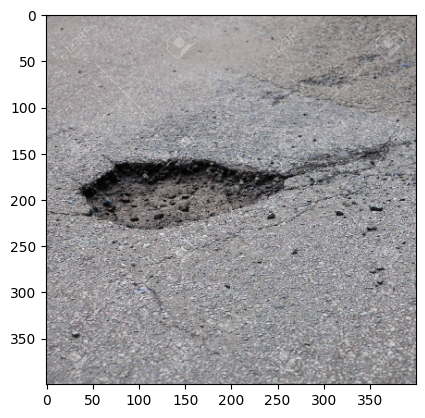

In [ ]:
plt.imshow(img_resized)

In [ ]:
img_reshaped = np.reshape(img_resized,(1,400,400,3))

In [ ]:
pred = model_one_epoch.predict(img_reshaped)

In [ ]:
mask1,mask2,mask3,mask4 = pred

In [ ]:
mask1_reshaped,mask2_reshaped,mask3_reshaped,mask4_reshaped = np.reshape(mask1,(400,400,3)),np.reshape(mask2,(400,400,3)),np.reshape(mask3,(400,400,3)),np.reshape(mask4,(400,400,3))

In [ ]:
mask4_reshaped[0][0]

array([0.93949807, 0.03857713, 0.02192483], dtype=float32)

In [ ]:
#######################################################################

In [ ]:
# Add mean iou with sparse_y_pred as false and set initial epoch
# stop1 = datetime.now()
# #Execution time of the model
# execution_time_Unet = stop1-start1
# print("UNet execution time is: ", execution_time_Unet)

# unet3plus.save('unet3plus.hdf5')

UNet execution time is:  2:01:31.392958


In [ ]:
# Continuing the training

In [ ]:
unet3plus10epochs = load_model('/content/gdrive/MyDrive/unet models/unet3plus.hdf5')


In [ ]:
earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

In [ ]:
model_path = '/content/gdrive/MyDrive/unet models/unet3plusCT.hdf5'
checkpoint = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

In [ ]:
start1 = datetime.now()
history = unet3plus10epochs.fit(train_img_gen,
                        validation_data=val_img_gen,
                        steps_per_epoch=steps_per_epoch,
                        validation_steps=val_steps_per_epoch,
                   verbose=1,
                   batch_size = batch_size,
                   epochs=30,
                   callbacks=[earlystop,checkpoint]
                   )




Epoch 1/30
500/500 [==============================] - ETA: 0s - loss: 0.8580 - unet3plus_output_sup0_activation_loss: 0.0376 - unet3plus_output_sup1_activation_loss: 0.2841 - unet3plus_output_sup2_activation_loss: 0.5027 - unet3plus_output_final_activation_loss: 0.0337 - unet3plus_output_sup0_activation_accuracy: 0.9886 - unet3plus_output_sup1_activation_accuracy: 0.9877 - unet3plus_output_sup2_activation_accuracy: 0.9872 - unet3plus_output_final_activation_accuracy: 0.9892
Epoch 00001: val_loss improved from inf to 0.83587, saving model to /content/gdrive/MyDrive/unet models/unet3plusCT.hdf5
500/500 [==============================] - 1342s 3s/step - loss: 0.8580 - unet3plus_output_sup0_activation_loss: 0.0376 - unet3plus_output_sup1_activation_loss: 0.2841 - unet3plus_output_sup2_activation_loss: 0.5027 - unet3plus_output_final_activation_loss: 0.0337 - unet3plus_output_sup0_activation_accuracy: 0.9886 - unet3plus_output_sup1_activation_accuracy: 0.9877 - unet3plus_output_sup2_activat

In [ ]:
stop1 = datetime.now()
#Execution time of the model
execution_time_Unet = stop1-start1
print("UNet execution time is: ", execution_time_Unet)

UNet execution time is:  6:14:57.828717


In [ ]:
unet3plus10epochs.save('unet3plus40epoch.hdf5')

In [ ]:
unet3plus10epochs.save('/content/gdrive/MyDrive/unet models/unet3plus40epoch.hdf5')

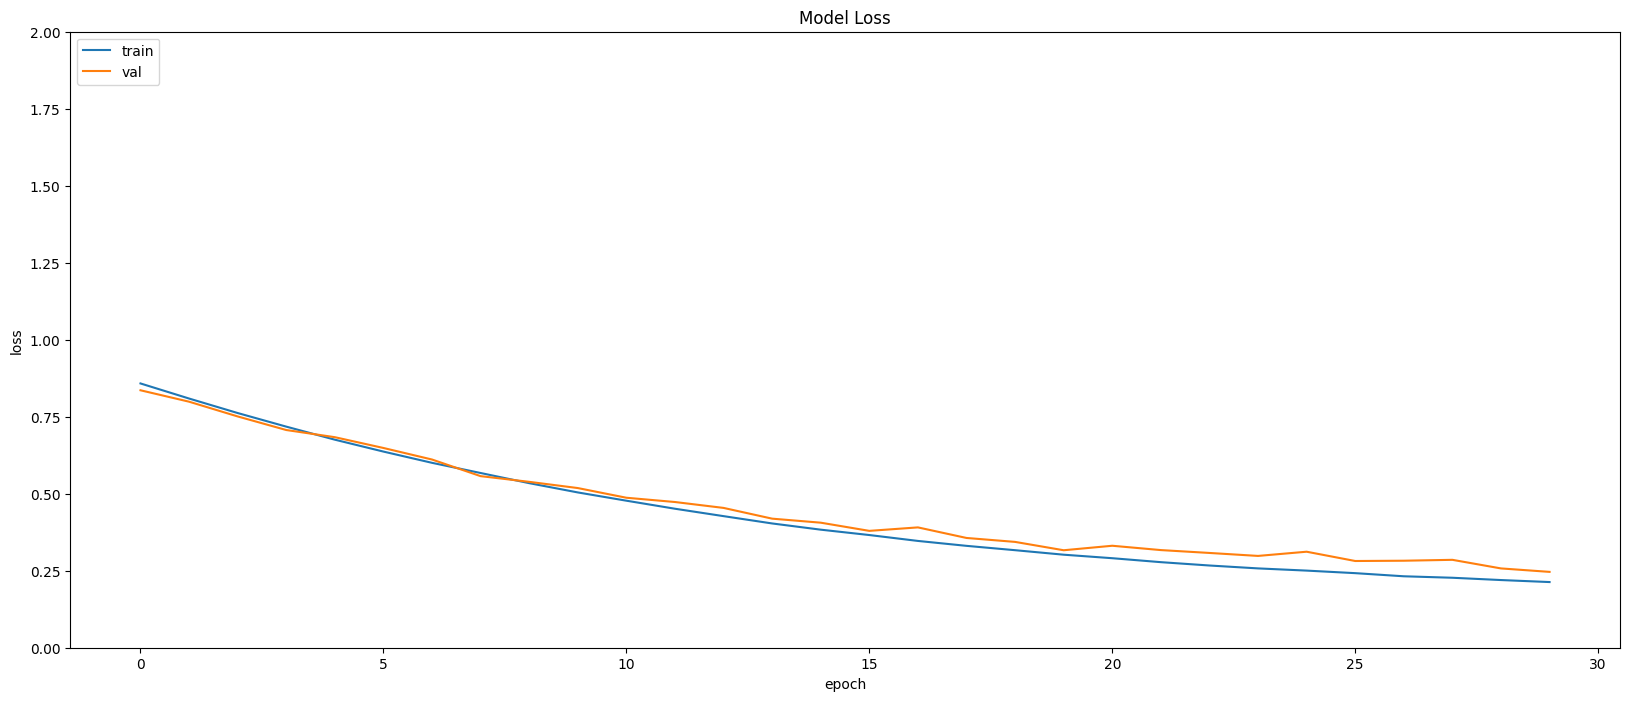

In [ ]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,2])
plt.legend(['train', 'val'], loc='upper left')
plt.show()

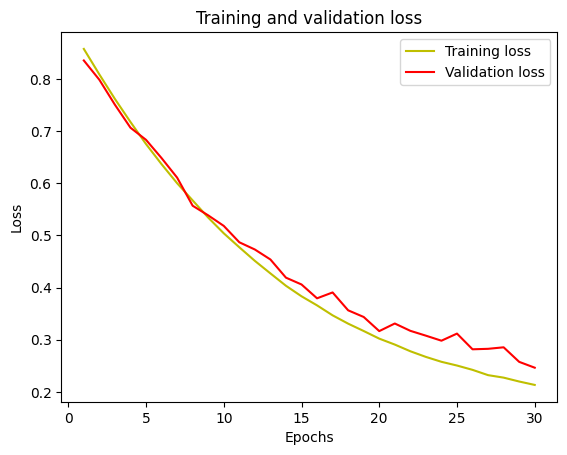

In [ ]:
# Probably same plots
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# acc = history.history['dice_coef']
# #acc = history.history['accuracy']
# val_acc = history.history['val_dice_coef']
# #val_acc = history.history['val_accuracy']

# plt.plot(epochs, acc, 'y', label='Training Dice')
# plt.plot(epochs, val_acc, 'r', label='Validation Dice')
# plt.title('Training and validation Dice')
# plt.xlabel('Epochs')
# plt.ylabel('Dice')
# plt.legend()
# plt.show()

In [ ]:
unet3plus40epochs = load_model('/content/gdrive/MyDrive/unet models/unet3plus40epoch.hdf5')

In [ ]:
random_val_samples = val_img_gen.__next__()
val_image_samples = random_val_samples[0]
val_mask_samples = random_val_samples[1]
predicted_masks = unet3plus40epochs.predict(val_image_samples)

#predicted_masks[predicted_masks >= 0.5] = 1
#predicted_masks[predicted_masks < 0.5] = 0

1/1 [==============================] - 1s 1s/step


In [ ]:
pred_arr = np.array(predicted_masks)

In [ ]:
pred_arr[pred_arr >= 0.5] = 1
pred_arr[pred_arr < 0.5] = 0

In [ ]:
pred_arr.shape

(4, 4, 400, 400, 3)

In [ ]:
val_image_samples.shape

(4, 400, 400, 3)

In [ ]:
pred_arr = np.array(predicted_masks)

In [ ]:
pred_arr.shape

(4, 4, 400, 400, 3)

In [ ]:
np.unique(pred_arr)

array([3.4812284e-26, 8.6421271e-26, 1.5506196e-25, ..., 9.9999976e-01,
       9.9999988e-01, 1.0000000e+00], dtype=float32)

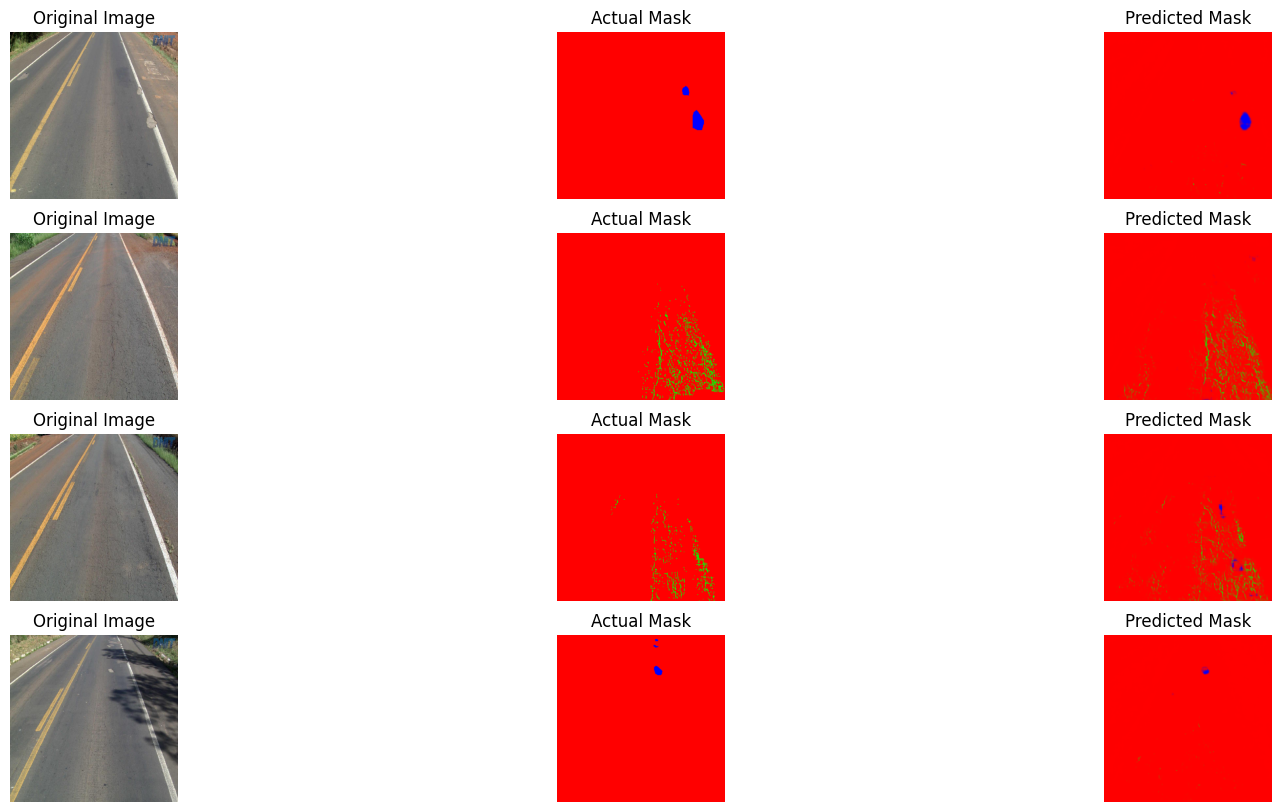

In [ ]:
#Ground Truth Masks vs Predicted Masks
f, axarr = plt.subplots(4,3,figsize=(20, 10))

for i in range(0,batch_size):

    axarr[i,0].imshow(val_image_samples[i].astype('uint8'))
    axarr[i,0].title.set_text('Original Image')
    axarr[i,0].axis('off')
    axarr[i,1].imshow(val_mask_samples[i],cmap='gray')
    axarr[i,1].title.set_text('Actual Mask')
    axarr[i,1].axis('off')
    axarr[i,2].imshow(pred_arr[3][i],cmap='gray')
    axarr[i,2].title.set_text('Predicted Mask')
    axarr[i,2].axis('off')

In [ ]:
rand_img_bgr = cv2.imread('/content/gdrive/MyDrive/cracks-and-potholes-in-road-test/images/919567_RS_290_290RS294095_31286.jpg')

In [ ]:
# Convert to RGB format
img_rgb = cv2.cvtColor(rand_img_bgr, cv2.COLOR_BGR2RGB)

In [ ]:
test_img = cv2.resize(img_rgb, (400, 400))

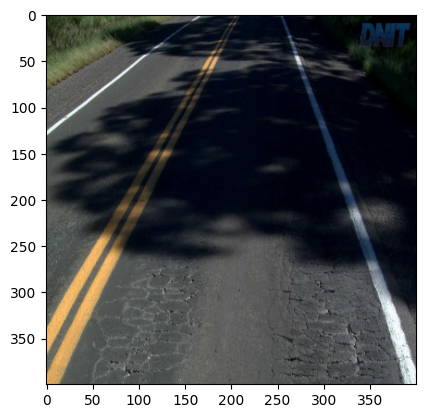

In [ ]:
plt.imshow(test_img)

In [ ]:
test_img.shape

(400, 400, 3)

In [ ]:
reshaped_img = np.reshape(test_img, (1, test_img.shape[0], test_img.shape[1], test_img.shape[2]))

In [ ]:
reshaped_img.shape

(1, 400, 400, 3)

In [ ]:
pred = unet3plus40epochs.predict(reshaped_img)

1/1 [==============================] - 5s 5s/step


In [ ]:
pred_arr = np.array(pred)

In [ ]:
pred_arr.shape

(4, 1, 400, 400, 3)

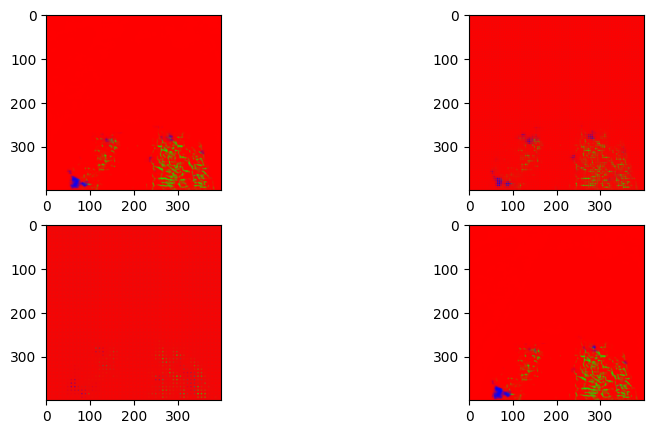

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(10, 5))
axs[0,0].imshow(pred_arr[0][0])
axs[0,1].imshow(pred_arr[1][0])
axs[1,0].imshow(pred_arr[2][0])
axs[1,1].imshow(pred_arr[3][0])
plt.show()

In [ ]:
test_image_batch, test_mask_batch = val_img_gen.__next__()

#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3)
test_pred_batch = unet3plus40epochs.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

1/1 [==============================] - 0s 44ms/step


In [ ]:
test_mask_batch_argmax.shape

(4, 400, 400)

In [ ]:
test_pred_batch_argmax.shape

(4, 4, 400, 3)

In [ ]:
np.array(test_pred_batch).shape

(4, 4, 400, 400, 3)

In [ ]:
test_pred_batch_argmax = np.argmax(test_pred_batch[0], axis=3)

In [ ]:
import random

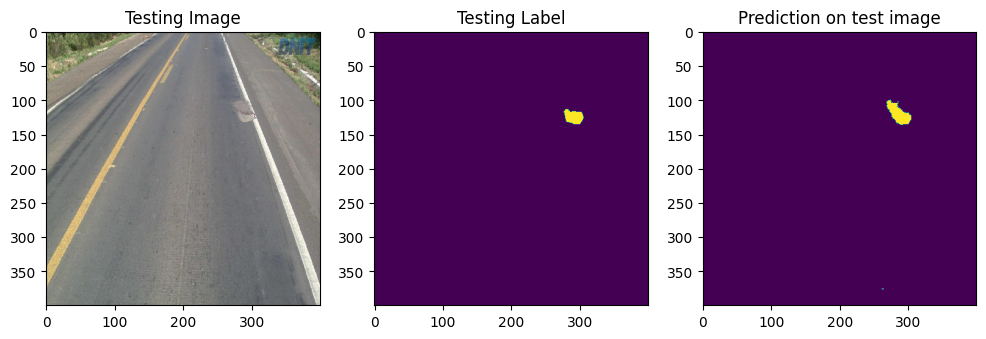

In [ ]:
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num].astype('uint8'))
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()

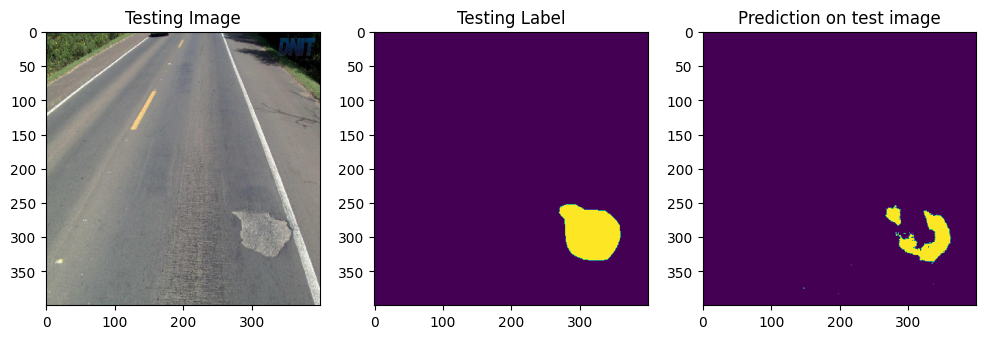

In [ ]:
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num].astype('uint8'))
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()

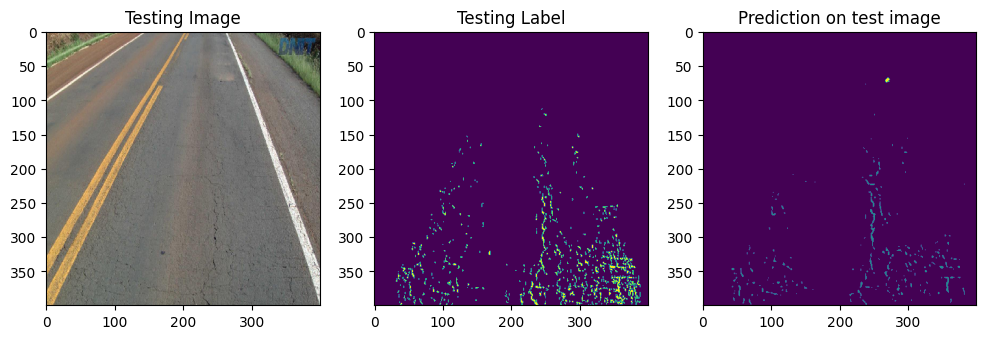

In [ ]:
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num].astype('uint8'))
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()

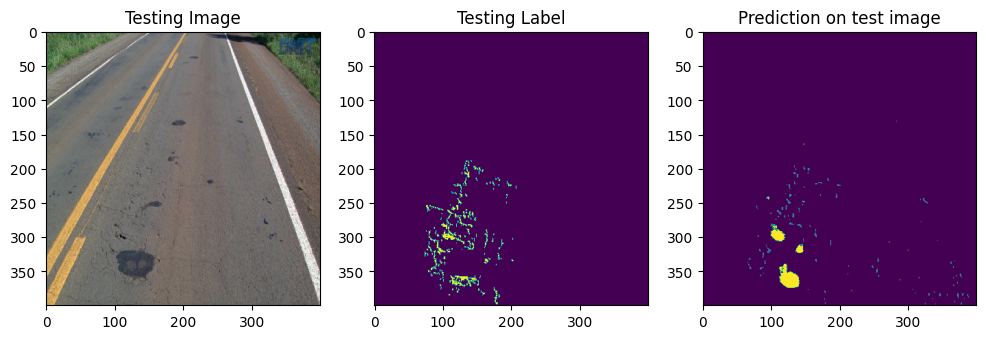

In [ ]:
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_image_batch[img_num].astype('uint8'))
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_pred_batch_argmax[img_num])
plt.show()